In [1]:
import array
import numpy as np
import scipy
from pydub.utils import get_array_type
from scipy.fft import fft


def frequency_spectrum(sample, max_frequency=4187):
    """
    Derive frequency spectrum of a signal pydub.AudioSample
    Returns an array of frequencies and an array of how prevelant that frequency is in the sample
    """
    # Convert pydub.AudioSample to raw audio data
    # Copied from Jiaaro's answer on https://stackoverflow.com/questions/32373996/pydub-raw-audio-data
    bit_depth = sample.sample_width * 8
    array_type = get_array_type(bit_depth)
    raw_audio_data = array.array(array_type, sample._data)
    n = len(raw_audio_data)

    # Compute FFT and frequency value for each index in FFT array
    # Inspired by Reveille's answer on https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
    freq_array = np.arange(n) * (float(sample.frame_rate) / n)  # two sides frequency range
    freq_array = freq_array[: (n // 2)]  # one side frequency range

    raw_audio_data = raw_audio_data - np.average(raw_audio_data)  # zero-centering
    freq_magnitude = fft(raw_audio_data)  # fft computing and normalization
    freq_magnitude = freq_magnitude[: (n // 2)]  # one side

    if max_frequency:
        max_index = int(max_frequency * n / sample.frame_rate) + 1
        freq_array = freq_array[:max_index]
        freq_magnitude = freq_magnitude[:max_index]

    freq_magnitude = abs(freq_magnitude)
    freq_magnitude = freq_magnitude / np.sum(freq_magnitude)
    return freq_array, freq_magnitude

In [2]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
import essentia
# import essentia.standard as es
from essentia.standard import *

In [3]:
# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
features, features_frames = MusicExtractor(lowlevelStats=['mean', 'stdev'], 
                                              rhythmStats=['mean', 'stdev'], 
                                              tonalStats=['mean', 'stdev'])('./audio/longwrongE4.m4a')
print("BPM:", features['rhythm.bpm'])
detected_bpm = features['rhythm.bpm']

BPM: 118.37188720703125


In [4]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

In [5]:
# Loading audio file
audio = MonoLoader(filename='./audio/longwrongE4.m4a')()

# Computing onset detection functions.
od1 = OnsetDetection(method='hfc')

w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
pool = essentia.Pool()


for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mag, phase, = c2p(fft(w(frame)))
    pool.add('features.hfc', od1(mag, phase))

# compute the actual onsets locations
onsets = Onsets()

onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]), [ 1 ])

72
[ 0.39473924  1.7995465   2.3219955   2.8096144   3.2972336   3.8429024
  4.3305216   4.7949204   5.3057594   5.804989    6.315828    6.815057
  7.836735    8.452064    8.602993    8.846803    9.822041   10.30966
 10.808888   11.308118   11.818957   12.306576   12.643266   12.829025
 13.305034   13.827483   14.094513   14.338322   14.849161   15.36
 15.882449   16.648708   16.927347   17.902586   18.436644   18.924263
 19.400272   19.876282   20.38712    20.64254    20.886349   21.397188
 21.884808   22.372427   22.616236   22.894875   23.405714   23.916553
 24.439003   24.96145    25.98313    26.447529   26.946758   27.434376
 27.945215   28.456055   28.932064   29.431292   29.942131   30.45297
 30.96381    31.46304    31.962267   32.774967   33.030384   35.13179
 35.42204    35.59619    35.73551    35.84       35.92127    36.19991   ]


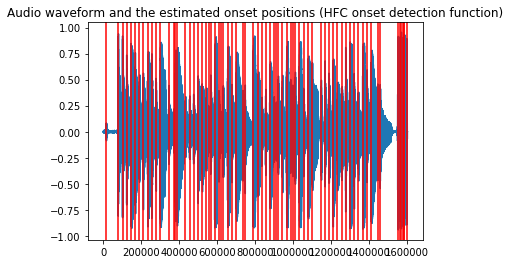

In [6]:
plot(audio)
for onset in onsets_hfc:
    plt.axvline(x=onset*44100, color='red')
    
print(len(onsets_hfc))
print(onsets_hfc)

plt.title("Audio waveform and the estimated onset positions (HFC onset detection function)")
plt.show()

In [7]:
from pydub import AudioSegment
import numpy as np

36309
36309


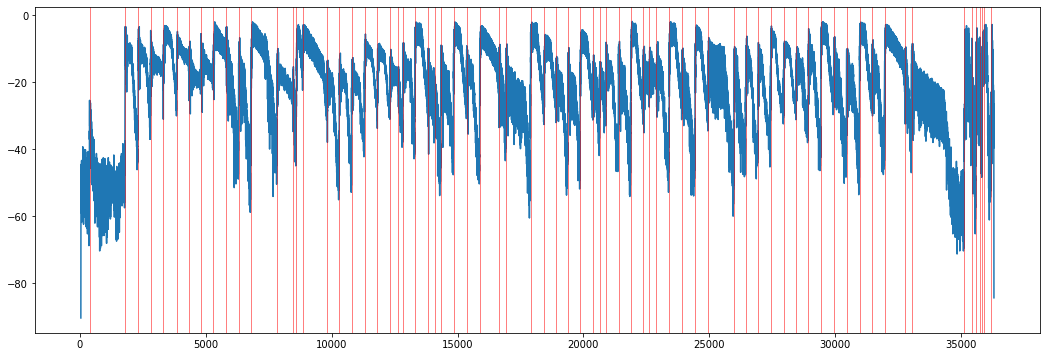

In [8]:
song = AudioSegment.from_file("./audio/longwrongE4.m4a")
print(len(song))
# Size of segments to break song into for volume calculations
SEGMENT_MS = 1
# dBFS is decibels relative to the maximum possible loudness
volume = [segment.dBFS for segment in song[::SEGMENT_MS]]
print(len(volume))
plt.rcParams['figure.figsize'] = (18, 6) # set plot sizes to something larger than default
x_axis = np.arange(len(volume))
plt.plot(x_axis, volume)
for s in onsets_hfc:
    plt.axvline(x=s*1000, color='r', linewidth=0.5, linestyle="-")
plt.show()

In [17]:
filter_time = []
i_range = 5
lowest_volume = -40
for s in onsets_hfc:
    s_i = int(s*1000)
    if (volume[s_i] > lowest_volume or 
        volume[s_i+i_range]>lowest_volume or 
        volume[s_i-i_range]>lowest_volume):
        filter_time.append(s*1000)
    else:
        print(s*1000)
        
# print(filter_time)
# print(len(filter_time))
detected_onsets = filter_time
# print(t_onsets)

In [18]:
c4 = 261.626
d4 = 293.665
e4 = 329.629
f4 = 349.228
g4 = 391.995
g3 = 195.998
standard_freqs = [e4,e4,f4,g4,
           g4,f4,e4,d4,
           c4,c4,d4,e4,
           e4,d4,d4,
           e4,e4,f4,g4,
           g4,f4,e4,d4,
           c4,c4,d4,e4,
           d4,c4,c4,
           d4,d4,e4,c4,
           d4,e4,f4,e4,c4,
           d4,e4,f4,e4,d4,
           c4,d4,g3,
           e4,e4,f4,g4,
           g4,f4,e4,d4,
           c4,c4,d4,e4,
           d4,c4,c4]
print(len(standard_freqs))

beat_index = [0,1,2,3,
              4,5,6,7,
              8,9,10,11,
              12,13.5,14,
              16,17,18,19,
              20,21,22,23,
              24,25,26,27,
              28,29.5,30,
              32,33,34,35,
              36,37,37.5,38,39,
              40,41,41.5,42,43,
              44,45,46,
              48,49,50,51,
              52,53,54,55,
              56,57,58,59,
              60,61.5,62]

note_duration = [1, 1, 1, 1,
                1, 1, 1, 1, 
                1, 1, 1, 1,
                1.5, 0.5, 2,
                1, 1, 1, 1, 
                1, 1, 1, 1, 
                1, 1, 1, 1, 
                1.5, 0.5, 2,
                1, 1, 1, 1, 
                1, 0.5, 0.5, 1, 1,
                1, 0.5, 0.5, 1, 1,
                1, 1, 2, 
                1, 1, 1, 1, 
                1, 1, 1, 1,
                1, 1, 1, 1, 
                1.5, 0.5, 2]
print(sum(note_duration))

bpm = 119
bt = 60 / bpm
bt_ms = bt*1000
audio_start_time = detected_onsets[1]

standard_onsets = []
#in ms
for i in beat_index:
    standard_onsets.append(audio_start_time + i*bt*1000)
    
print(len(standard_onsets))

62
64.0
62


[394.7392404079437, 1799.546480178833, 2321.995496749878, 2809.614419937134, 3297.2335815429688, 3842.902421951294, 4330.521583557129, 4794.920444488525, 5305.759429931641, 5804.988861083984, 6315.8278465271, 6815.056800842285, 7836.734771728516, 8452.06356048584, 8602.99301147461, 8846.802711486816, 9822.040557861328, 10309.659957885742, 10808.88843536377, 11308.117866516113, 11818.957328796387, 12306.575775146484, 12643.265724182129, 12829.025268554688, 13305.033683776855, 13827.483177185059, 14094.512939453125, 14338.321685791016, 14849.161148071289, 15359.999656677246, 15882.44915008545, 16648.70834350586, 16927.34718322754, 17902.585983276367, 18436.643600463867, 18924.26300048828, 19400.272369384766, 19876.28173828125, 20387.11929321289, 20642.539978027344, 20886.348724365234, 21397.188186645508, 21884.807586669922, 22372.426986694336, 22616.235733032227, 22894.874572753906, 23405.71403503418, 23916.553497314453, 24439.002990722656, 24961.450576782227, 25983.129501342773, 26447.5

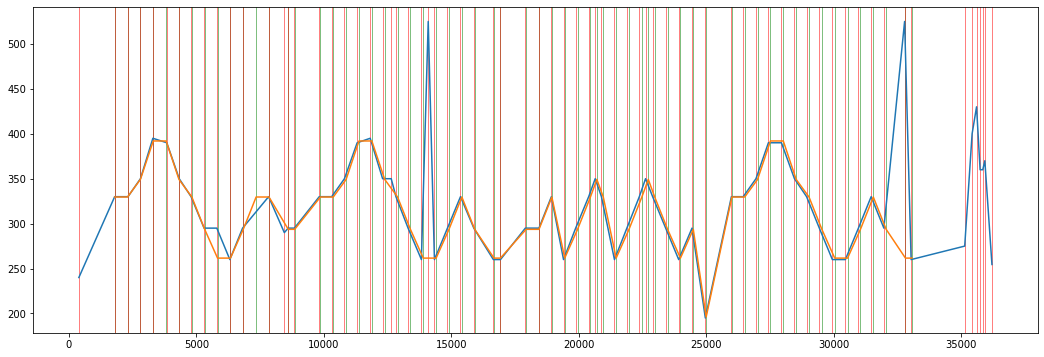

In [19]:
detected_freqs = []

for start in detected_onsets:
    sample_from = int(start)
    sample_to = int(start + 200)
    segment = song[sample_from:sample_to]
    freqs, freq_magnitudes = frequency_spectrum(segment)
#     print(freqs[np.argmax(freq_magnitudes)])
    detected_freqs.append(freqs[np.argmax(freq_magnitudes)])
    
# x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
for x in standard_onsets:
    plt.axvline(x=x, color='g', linewidth=0.5, linestyle="-")
    
for x in detected_onsets:
    plt.axvline(x=x, color='r', linewidth=0.5, linestyle="-")
    
plt.plot(detected_onsets, detected_freqs)
print(detected_onsets)

plt.plot(standard_onsets, standard_freqs)

# count error / distance
# count = 0
# for i in t_freqs:
#     print(i - s_freqs[count])
#     count = count + 1

In [22]:
notes = ["E4","E4","F4","G4",
           "G4","F4","E4","D4",
           "C4","C4","D4","E4",
           "E4","D4","D4",
           "E4","E4","F4","G4",
           "G4","F4","E4","D4",
           "C4","C4","D4","E4",
           "D4","C4","C4",
           "D4","D4","E4","C4",
           "D4","E4","F4","E4","C4",
           "D4","E4","F4","E4","D4",
           "C4","D4","G3",
           "E4","E4","F4","G4",
           "G4","F4","E4","D4",
           "C4","C4","D4","E4",
           "D4","C4","C4"]
def pretty_print(result, total_num):
    pretty_res = ""
    for i in range(0, total_num):
        pretty_res += (notes[i]+":"+result[i]+" | ")
    print(pretty_res)

In [25]:
#detected_onsets = [-10, 0, 9, 10, 31, 42, 56, 57.5, 60, 80, 90]
#detected_freqs = [10, 1, 2, 2, 4, 5, 6, 6, 7, 8, 10]
#standard_onsets = [0, 10, 20, 30, 40, 55, 60, 80]
#standard_freqs = [1, 2, 3, 4, 5, 6, 7, 8]
#total_num = 8
#note_duration = [1, 1, 1, 1, 1.5, 0.5, 2, 1]

#bt_ms = 10

total_num = 62
#this is time slices for splitting notes 
split_time = []
split_time.append((standard_onsets[0]- 0.5*bt_ms, standard_onsets[0]+0.5*note_duration[0]*bt_ms))
for i in range(1, total_num-1):
    min_time = standard_onsets[i]-0.5*note_duration[i-1]*bt_ms
    max_time = standard_onsets[i]+0.5*note_duration[i]*bt_ms
    split_time.append((min_time, max_time))
#change: the last one note duration
split_time.append((standard_onsets[total_num-1]-0.5*note_duration[total_num-2]*bt_ms, 
                   standard_onsets[total_num-1]+0.5*note_duration[total_num-1]*bt_ms))
print(len(split_time))


#each pair is a list of time, a list of freq for examine at a standard onset
examine_freqs = []
for i in range(0, total_num):
    examine_freqs.append(([],[]))

#separate the onsets into their positions
cur_onset = 0
for i in range(0, total_num):
    min_time = split_time[i][0]
    max_time = split_time[i][1]
    for j in range(cur_onset, len(detected_onsets)):
        t = detected_onsets[j]
        freq = detected_freqs[j]
        if (t<min_time):#before the first time slice, very beginning, pass
            cur_onset += 1
            continue
        elif (t>max_time):
            if (i==total_num-1):#final time slice, if >max time, pass all remaining onsets
                break
            else: #normal case, should stop and go to next time slice
                break
        else: #fall right into the slice
            (examine_freqs[i])[0].append(t)
            (examine_freqs[i])[1].append(freq)
            cur_onset += 1
              
print(examine_freqs)

result = ["False"]*total_num
#error tolerance of frequency
error_tol = 5
#for duplicate onsets, maybe because of onset detect error, permit a small time diff as only one note
dup_time_tol = 150
#for beat time error tolerance
beat_error_tol = 150
correct_count = 0
freq_error_count = 0
beat_error_count = 0
for i in range(0, total_num):
    examine_t = examine_freqs[i][0]
    examine_f = examine_freqs[i][1]
    standard_t = standard_onsets[i]
    standard_f = standard_freqs[i]
    min_freq = standard_f - error_tol
    max_freq = standard_f + error_tol
    min_time = standard_t - beat_error_tol
    max_time = standard_t + beat_error_tol
    detected_num = len(examine_f)
    if detected_num > 1: # play more notes 
        max_time_diff = 0
        for n in range(1, detected_num):
            time_diff = examine_t[n]-examine_t[n-1]
            if time_diff>max_time_diff:
                max_time_diff = time_diff
        if max_time_diff <= dup_time_tol:
            result[i] = "True"
            correct_count += 1
        else:
            result[i] = "Dup"
            beat_error_count += 1
    elif detected_num < 1: # miss the note
        result[i] = "Miss"
    else:#only one note, see freq
        if ((examine_t[0] >= min_time) and (examine_t[0] <= max_time)):#regard as correct beat
            if ((examine_f[0] >= min_freq) and (examine_f[0] <= max_freq)):#correct freq
                result[i] = "True"
                correct_count += 1
            else:
                result[i] = "WrongFreq"
                freq_error_count += 1
        else:
            result[i] = "WrongBeat"
            beat_error_count += 1
pretty_print(result, total_num)
print("correct_count:", correct_count)
print("freq_error", freq_error_count)
print("beat_error", beat_error_count)
print("detected bpm", detected_bpm)

#overall report
#frequency accuracy: percentage
freq_accuracy = (total_num - freq_error_count)/total_num
freq_score = int(freq_accuracy*100)
print("freq_score",freq_score)
#beat accuracy: percentage, take into account:dup and wrongbeat
beat_accuracy = (total_num - beat_error_count)/total_num
beat_score = int(beat_accuracy*100)
print("beat_score", beat_score)
#speed: 
speed = detected_bpm
speed_score = int((1-(abs(bpm - detected_bpm)/bpm))*100)
print("speed_score", speed_score)
# correctness: percentage
correctness = correct_count/total_num
correctness_score = int(correctness*100)
print("correctness_score", correctness_score)
                
    
    

 

62
[([1799.546480178833], [330.0]), ([2321.995496749878], [330.0]), ([2809.614419937134], [350.0]), ([3297.2335815429688], [395.0]), ([3842.902421951294], [390.0]), ([4330.521583557129], [350.0]), ([4794.920444488525], [330.0]), ([5305.759429931641], [295.0]), ([5804.988861083984], [295.0]), ([6315.8278465271], [260.0]), ([6815.056800842285], [295.0]), ([], []), ([7836.734771728516], [330.0]), ([8452.06356048584, 8602.99301147461], [290.0, 295.0]), ([8846.802711486816], [295.0]), ([9822.040557861328], [330.0]), ([10309.659957885742], [330.0]), ([10808.88843536377], [350.0]), ([11308.117866516113], [390.0]), ([11818.957328796387], [395.0]), ([12306.575775146484], [350.0]), ([12643.265724182129, 12829.025268554688], [350.0, 330.0]), ([13305.033683776855], [295.0]), ([13827.483177185059, 14094.512939453125], [260.0, 525.0]), ([14338.321685791016], [260.0]), ([14849.161148071289], [295.0]), ([15359.999656677246], [330.0]), ([15882.44915008545], [295.0]), ([16648.70834350586], [260.0]), ([1